In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools


from statsmodels.tsa.stattools import grangercausalitytests, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# estacionarieidad
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# test durbin watson
from statsmodels.stats.stattools import durbin_watson

In [2]:
df = pd.read_excel("../Datos/Acciones.xlsx",sheet_name=0)

In [427]:
class Portafolio:

    INDICES = ["76_CHL_IGPA_INDICE","77_COL_COLCAP_INDICE","78_MEX_IPC_INDICE","79_PER_LIMA GENER_INDICE"]
    PERIODO = ["PERIODO"]

    def __init__(self,df):
        self.df = df
        self.tickers_info_full = self.df.columns.to_list()
        self.tickers_info_full.remove("PERIODO")
        [self.tickers_info_full.remove(indice) for indice in Portafolio.INDICES]
        self.df_final = self.df[self.tickers_info_full]
        self.test = 'ssr_chi2test'
    
    def create_df_tickers(self,list_tickers):
        tickers_info_df = pd.DataFrame(list_tickers, columns = ["column_id"])
        tickers_info_df["pais"] = tickers_info_df["column_id"].apply(lambda x: x.split("_")[1])
        self.tickers_info_df = tickers_info_df

    def permutations_tickers(self, *args, **kwargs):
        s = list(itertools.permutations(*args, **kwargs))
        ids = dict()
        for id in s:
            value_1 = id[0].split("_")[1]
            value_2 = id[1].split("_")[1]
            if value_1==value_2:
                ids[id] = 1
            else:
                ids[id] = 0

        ids_filters = [id for id in ids if ids[id] == 0]
        self.ids_filters = ids_filters
        
    def analysis_df(self,par_var):
        lista = Portafolio.PERIODO.copy()
        lista.extend(par_var)
        new_df = self.df.copy()
        new_df = new_df[lista]
        new_df = new_df.set_index("PERIODO")
        return new_df
        
    def transform_df(self,df,type_transform=None,remove_na=None):
        
        df_edit = df.copy()
        new_columns_org = df_edit.columns.tolist()

        if type_transform=="returns":            
            new_columns = ["returns_"+column for column in new_columns_org]

            for column in new_columns:
                df_edit[column] = np.log(df_edit[column.replace("returns_","")]).diff()
        
        elif type_transform=="diff":
            new_columns = ["diff_"+column for column in new_columns_org]

            for column in new_columns:
                df_edit[column] = df_edit[column.replace("diff_","")].diff()

        if type_transform:
            df_edit.drop(new_columns_org,axis=1,inplace=True)
        
        # calidad de la salida
        print("Nas:",df_edit.isna().sum())

        if remove_na:
            df_edit.dropna(inplace=True,axis=0)
            print("Correccion")
            print("Nas:",df_edit.isna().sum())

        self.apply_all(inside=True,df=df_edit.columns.tolist())
        
        return df_edit
    
    def adfuller_test_results(self,b):
        # pruebas de estacionarieidad para todas las series
        results_adftest = {}
        for column in b.columns.tolist():
            print(column)
            adf = adfuller(b[column])
            results_adftest[column] = adf[1]

        vals = np.fromiter(results_adftest.values(), dtype=float)

        return list(results_adftest,vals)
    
    def var_model_results(self,b):
        models_results_by_lags = {}
        model = VAR(b)
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
            result = model.fit(i)
            models_results_by_lags[i] = {"AIC":result.aic,
                                "BIC":result.bic,
                                'FPE': result.fpe,
                                'HQIC':result.hqic}

        self.list_AIC = [abs(models_results_by_lags[id]["AIC"]) for id in np.arange(1,16)]
        self.maxlag = self.list_AIC.index(min(self.list_AIC))+1

        self.results = model.fit(maxlags=self.maxlag, ic='aic')

        return models_results_by_lags
    
    def durbin_watson_df(self):
        out = durbin_watson(self.results.resid)
        df_out = pd.DataFrame(out, columns={"result"})
        df_out["no_correlation"] = df_out["result"].apply(lambda x: x==2.0)
        return df_out

    def grangers_causation_matrix(self, data):    
        salida = pd.DataFrame(Portafolio.ids_filters, columns = ["var1","var2"])
        salida["p-value"] = np.nan

        for id,pair in enumerate(Portafolio.ids_filters):
            test_result = grangercausalitytests(data[list(pair)], maxlag=[self.maxlag], verbose=False) # remover parentesis en maxlag
            # p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]     
            p_values = round(test_result[self.maxlag][0][self.test][1],4)
            # min_p_value = np.min(p_values)
            # salida.iloc[id,2] = min_p_value
            salida.iloc[id,2] = p_values
        return salida
    
    def clean_output_model(self,df):
        final_df = df.copy()
        final_df["pass_test"] = final_df["p-value"]<0.05
        final_df = final_df[final_df["pass_test"]==True]
        final_df["pais_var1"] = final_df["var1"].apply(lambda x: x.split("_")[2])
        final_df["pais_var2"] = final_df["var2"].apply(lambda x: x.split("_")[2])
        final_df = final_df[final_df["pais_var1"]!=final_df["pais_var2"]]
        final_df["lista1"] = final_df["var1"].apply(lambda x: x.join(final_df["var2"]))
        final_df["lista2"] = final_df["var2"].apply(lambda x: x.join(final_df["var1"]))
        final_df["final_val"] = final_df["lista1"]==final_df["lista2"]
        stocks_porfolio_1 = final_df[["var1","var2","p-value"]]
        return stocks_porfolio_1
     
    def apply_all(self,inside=False,df=None):

        if inside:
            self.create_df_tickers(list_tickers=df)
            self.permutations_tickers(iterable=self.tickers_info_df["column_id"],r=2)
        
        else:
            self.create_df_tickers(list_tickers=self.tickers_info_full)
            self.permutations_tickers(iterable=self.tickers_info_df["column_id"],r=2)
    
    def apply_model(self,df):
        x = self.var_model_results(df)
        

In [428]:
Portafolio = Portafolio(df)
Portafolio.apply_all()

# Diferencias vs Rendimientos

In [425]:
# vars = list(Portafolio.ids_filters[0])
# a = Portafolio.analysis_df(par_var = vars)
b = Portafolio.transform_df(df=Portafolio.df_final, type_transform="returns",remove_na=True)
Portafolio.apply_model(b)

Nas: returns_1_CHL_AGUAS_SERV. P              1
returns_2_CHL_ANDINA_CONS. BAS           1
returns_3_CHL_ANTAR_ENER                 1
returns_4_CHL_BANCO CREDITO_FINAN        1
returns_5_CHL_BANCO STDER_FINAN          1
                                        ..
returns_71_PER_FERREYROS_INDUST          1
returns_72_PER_ACEROS AREQUIPA_MATER     1
returns_73_PER_EMP. SIDERURGICA_MATER    1
returns_74_PER_CASA GRANDE_CONS. BAS     1
returns_75_PER_TREVALI MINING_MATER      1
Length: 75, dtype: int64
Correccion
Nas: returns_1_CHL_AGUAS_SERV. P              0
returns_2_CHL_ANDINA_CONS. BAS           0
returns_3_CHL_ANTAR_ENER                 0
returns_4_CHL_BANCO CREDITO_FINAN        0
returns_5_CHL_BANCO STDER_FINAN          0
                                        ..
returns_71_PER_FERREYROS_INDUST          0
returns_72_PER_ACEROS AREQUIPA_MATER     0
returns_73_PER_EMP. SIDERURGICA_MATER    0
returns_74_PER_CASA GRANDE_CONS. BAS     0
returns_75_PER_TREVALI MINING_MATER      0
Length: 

d:\AnalisisAcciones\acciones\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [426]:
df_test = Portafolio.grangers_causation_matrix(data=b)

In [429]:
stocks_porfolio_1 = Portafolio.clean_output_model(df_test)

In [430]:
stocks_porfolio_1

,var1,var2,p-value
30,returns_1_CHL_AGUAS_SERV. P,returns_32_COL_BANCOLOMBIA_FINAN,0.0009
31,returns_1_CHL_AGUAS_SERV. P,returns_33_COL_ECOPETROL_ENER,0.0010
32,returns_1_CHL_AGUAS_SERV. P,returns_34_COL_ENER. BOGOTA_SERV. P,0.0001
33,returns_1_CHL_AGUAS_SERV. P,returns_35_COL_SURAMERICANA_FINAN,0.0001
34,returns_1_CHL_AGUAS_SERV. P,returns_36_COL_INTERCON. ELECTRICA_INDUST,0.0000
...,...,...,...
5521,returns_75_PER_TREVALI MINING_MATER,returns_46_MEX_CEMEX_MATER,0.0004
5525,returns_75_PER_TREVALI MINING_MATER,returns_50_MEX_GRUPO CARSO_CONS. DISCRE,0.0430
5526,returns_75_PER_TREVALI MINING_MATER,returns_51_MEX_INBURSA_FINAN,0.0406
5527,returns_75_PER_TREVALI MINING_MATER,returns_52_MEX_BANORTE_FINAN,0.0427


<AxesSubplot:>

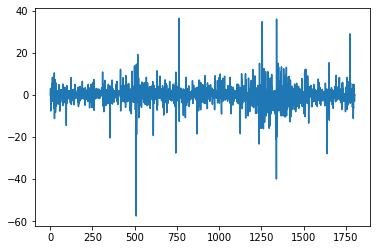

In [365]:
# Portafolio.df["1_CHL_AGUAS_SERV. P"].plot()
b["diff_1_CHL_AGUAS_SERV. P"].plot()

<AxesSubplot:>

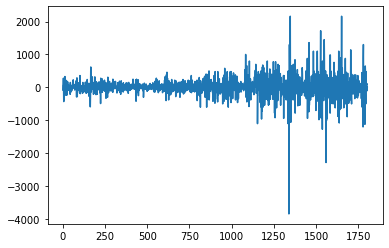

In [366]:
# Portafolio.df["36_COL_INTERCON. ELECTRICA_INDUST"].plot()
b["diff_36_COL_INTERCON. ELECTRICA_INDUST"].plot()